In [1]:
from benchmark.testsystems import double_well
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
%matplotlib inline

OpenMM version:  7.2.0.dev-fb607c7
OpenMM version:  7.2.0.dev-fb607c7
	Removing CMMotionRemover
	Removing CMMotionRemover
Desired platform not supported
Desired platform not supported
Desired platform not supported
Desired platform not supported
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported
	Removing CMMotionRemover
Desired platform not supported


In [2]:
from benchmark.testsystems import NumbaNonequilibriumSimulator
from benchmark.integrators import vvvr_factory, baoab_factory, orvro_factory, aboba_factory

In [3]:
ovrvo = vvvr_factory(double_well.potential, double_well.force, double_well.velocity_scale, double_well.mass)
vrorv = baoab_factory(double_well.potential, double_well.force, double_well.velocity_scale, double_well.mass)
rvovr = aboba_factory(double_well.potential, double_well.force, double_well.velocity_scale, double_well.mass)
orvro = orvro_factory(double_well.potential, double_well.force, double_well.velocity_scale, double_well.mass)

gamma = 10.0
dt = 0.7

In [4]:
double_well.mass

10.0

In [5]:
x0 = double_well.sample_x_from_equilibrium()
v0 = double_well.sample_v_given_x(x0)

integrators = {'VRORV':vrorv, 'OVRVO': ovrvo, 'ORVRO': orvro, 'RVOVR': rvovr}

def integrate(x0, v0, n_steps, dt=0.6, scheme='VRORV'):
    return integrators[scheme](x0, v0, n_steps, gamma, dt)

x_orvro,v_orvro = integrate(x0, v0, 1000000, scheme='ORVRO')[:2]
x_ovrvo,v_ovrvo = integrate(x0, v0, 1000000, scheme='OVRVO')[:2]
x_rvovr,v_rvovr = integrate(x0, v0, 1000000, scheme='RVOVR')[:2]
x_vrorv,v_vrorv = integrate(x0, v0, 1000000, scheme='VRORV')[:2]

Cache found: loading...
Loading equilibrium samples from /Users/joshuafass/Documents/Code/integrator-benchmark/benchmark/../data/double_well_samples.npy...


In [6]:
np.vstack([x_orvro, v_orvro]).T.shape

(1000000, 2)

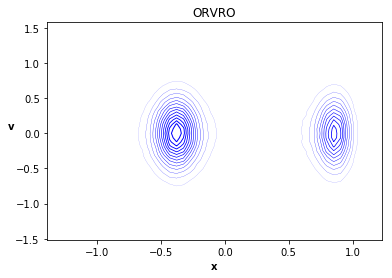

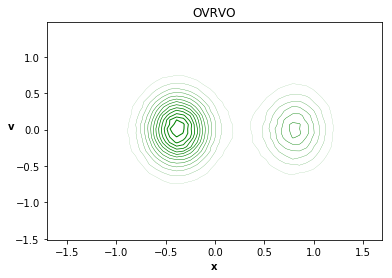

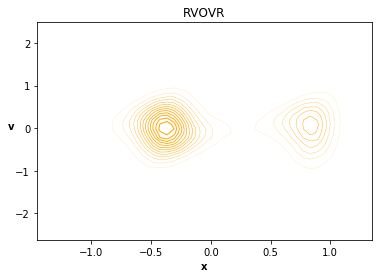

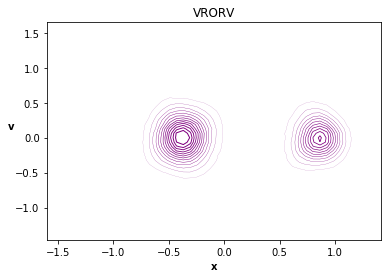

In [77]:
def plot_contours(x,v, color='purple'):
    H, xedges, yedges = np.histogram2d(x,v,bins=50)
    levels = np.linspace(np.min(H), np.max(H), 15)[1:]
    #levels = sorted(list(set(sorted(H.flatten())[::int(len(H.flatten()) / 50)])))[1:]
    linewidths = np.linspace(0,1,len(levels)) + 0.1
    plt.contour(H.T,
                extent=(min(xedges), max(xedges), min(yedges), max(yedges)),
                colors=color, levels=levels, linewidths=linewidths)
    plt.xlabel(r'$\mathbf{x}$')
    plt.ylabel(r'$\mathbf{v}$', rotation=0)

plt.figure()
plot_contours(x_orvro, v_orvro, 'blue')
plt.title('ORVRO')

plt.figure()
plot_contours(x_ovrvo, v_ovrvo, 'green')
plt.title('OVRVO')

plt.figure()
plot_contours(x_rvovr, v_rvovr, 'orange')
plt.title('RVOVR')

plt.figure()
plot_contours(x_vrorv, v_vrorv, 'purple')
plt.title('VRORV')

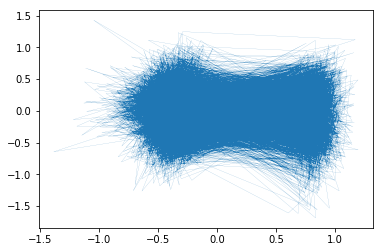

In [8]:
plt.plot(x_rvovr[::100], v_rvovr[::100], linewidth=0.1)

In [9]:
# what's the ground-truth density look like
x_grid = np.linspace(-1.75,1.75,1000)
y_grid = np.exp(double_well.log_q(x_grid))

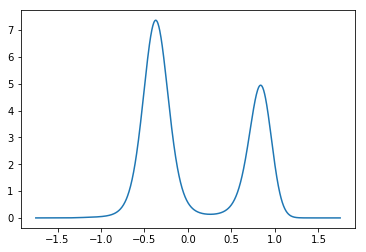

In [10]:
plt.plot(x_grid, y_grid)

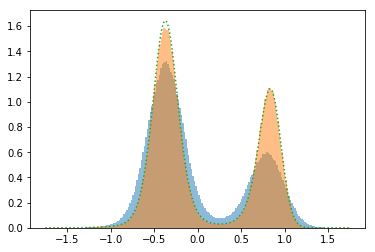

In [11]:
plt.hist(x_ovrvo, bins=200, normed=True, alpha=0.5);
plt.hist(x_vrorv, bins=200, normed=True, alpha=0.5);
plt.plot(x_grid, y_grid / np.trapz(y_grid, x_grid), linestyle='dotted')

(-2, 6)

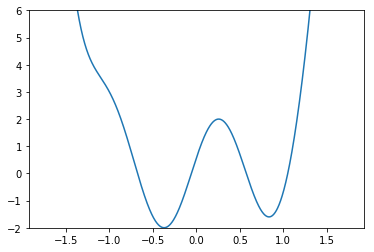

In [12]:
plt.plot(x_grid, double_well.potential(x_grid))
plt.ylim(-2,6)

In [13]:
all_x = [x_orvro, x_ovrvo, x_rvovr, x_vrorv]
x_min = np.min(all_x)
x_max = np.max(all_x)

all_v = [v_orvro, v_ovrvo, v_rvovr, v_vrorv]
v_min = np.min(all_v)
v_max = np.max(all_v)


hist_range = [[x_min, x_max], [v_min, v_max]]
hist_range

[[-1.7018397790875786, 1.6846414405347678],
 [-2.6215545798081576, 2.4871848665854328]]

In [14]:
n_bins = 100

In [15]:
counts, x2_grid, v2_grid = np.histogram2d(x_rvovr, v_rvovr, bins=n_bins, range=hist_range)

In [16]:
x_grid = np.linspace(-2.25,2.25,100000)
y_grid = np.exp(double_well.log_q(x_grid))
Z = np.trapz(y_grid, x_grid)
Z

4.4848163908378549

In [17]:
def p(x):
    return np.exp(double_well.log_q(x)) / Z

x_grid = np.linspace(-2,2,10000)
y_grid = p(x_grid)
np.trapz(y_grid, x_grid)

1.0

In [18]:
sigma2 = double_well.velocity_scale**2

def log_v_density(v):
    return -v ** 2 / (2 * sigma2) - np.log((np.sqrt(2 * np.pi * sigma2)))

def v_density(v):
    return np.exp(log_v_density(v))

In [19]:
def integrate_on_grid(grid, p, n_trapz_bins=1000):
    exact_hist = np.zeros(len(grid) - 1)
    for i, (left, right) in enumerate(zip(grid[:-1], grid[1:])):
        
        trapz_grid = np.linspace(left, right, n_trapz_bins)
        y = p(trapz_grid)
        exact_hist[i] = np.trapz(y, trapz_grid)
    return exact_hist

exact_hist_x = integrate_on_grid(x2_grid, p)
exact_hist_v = integrate_on_grid(v2_grid, v_density)

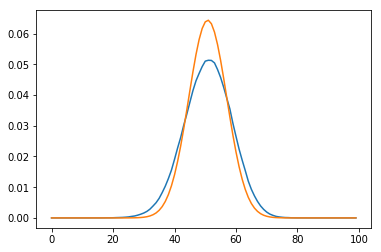

In [20]:
plt.plot(counts.sum(0) / np.sum(counts))
plt.plot(exact_hist_v)

In [21]:
hist_density = counts / np.sum(counts)

In [22]:
rho_x = hist_density.sum(1)
pi_x = exact_hist_x

In [23]:
x_grid = (x2_grid[1:] + x2_grid[:-1])/2
v_grid = (v2_grid[1:] + v2_grid[:-1])/2

In [24]:
def plot_rho_x_diff(rho_x, color='blue', scheme=None, ax=None):

    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
    plt.plot(x_grid, pi_x, color='grey', label='equilibrium')
    plt.plot(x_grid, rho_x, color=color, linestyle='--', label=scheme)
    
    fill_alpha = 0.2
    
    # rho(x) > pi(x)
    plt.fill_between(x_grid, rho_x, pi_x, where=(rho_x > pi_x), alpha=fill_alpha, color=color, hatch='///')
    
    # rho(x) < pi(x)
    plt.fill_between(x_grid, rho_x, pi_x, where=(rho_x < pi_x), alpha=fill_alpha, color=color)
    
    x_ticks = [-1,0,1]
    plt.xticks(x_ticks, map(str, x_ticks))
    
    plt.yticks([])
    plt.xlabel(r'$x$')
    
    plt.ylim(0,)

In [25]:

x_fine_grid_mid = np.linspace(0,0.5, 10000)
exact_x_midpoint = x_fine_grid_mid[np.argmax(double_well.potential(x_fine_grid_mid))]
exact_x_midpoint

0.25677567756775677

In [26]:
def get_density_and_observables(scheme, dt=0.5, n_samples=10000000):
    
    x, v = integrate(x0, v0, n_samples, dt=dt, scheme=scheme)[:2]
    
    n_skip = 1000
    x, v = x[n_skip:], v[n_skip:]
    
    counts = np.histogram2d(x, v, bins=n_bins, range=hist_range)[0]
    rho = counts / np.sum(counts)
    
    # compute free energy difference between the wells
    pi_left = sum(x < exact_x_midpoint) / len(x)
    pi_right = 1 - pi_left
    free_energy_diff = np.log(pi_left / pi_right)

    return {'rho': rho,
            'rho_x': rho.sum(1),
            'free_energy_diff': free_energy_diff,
            'avg_potential': np.mean(double_well.potential(x))
           }

In [27]:
from tqdm import tqdm
dts = np.linspace(0.1,0.70)

schemes = ['OVRVO', 'ORVRO', 'VRORV', 'RVOVR']
def get_results(scheme='OVRVO'):
    results = []
    for dt in tqdm(dts):
        results.append(get_density_and_observables(scheme, dt))
    return results

all_results = dict()
for scheme in schemes:
    all_results[scheme] = get_results(scheme)

phase_space_rhos = dict()
conf_space_rhos = dict()
free_energy_diffs = dict()
avg_potentials = dict()

 88%|████████▊ | 44/50 [13:32<01:52, 18.74s/it]/Users/joshuafass/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:968: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])
/Users/joshuafass/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':
/Users/joshuafass/Documents/Code/integrator-benchmark/benchmark/testsystems/low_dimensional_systems.py:134: RuntimeWarning: overflow encountered in power
  double_well = NumbaBookkeepingSimulator(potential=lambda x: x ** 6 + 2 * np.cos(5 * (x + 1)),
/Users/joshuafass/Documents/Code/integrator-benchmark/benchmark/testsystems/low_dimensional_systems.py:134: RuntimeWarning: invalid value encountered in cos
  double_well = NumbaBookkeepingSimulator(potential=lambda x: x ** 6 + 2 * np.cos(5 * (x + 1)),
100%|██████████| 50/50 [14:05<00:00, 16.08s/it]


In [28]:
for scheme in schemes:
    phase_space_rhos[scheme] = [result['rho'] for result in all_results[scheme]]
    conf_space_rhos[scheme] = [result['rho_x'] for result in all_results[scheme]]
    free_energy_diffs[scheme] = [result['free_energy_diff'] for result in all_results[scheme]]
    avg_potentials[scheme] = [result['avg_potential'] for result in all_results[scheme]]

In [29]:
exact_hist_xv = np.outer(exact_hist_x, exact_hist_v)

In [30]:
phase_space_rhos['equilibrium'] = exact_hist_xv

In [31]:
from pickle import dump

with open('1d_results.pkl', 'wb') as f:
    dump({'noneq_results': all_results,
          'eq_dist': exact_hist_xv,
          'midpoint_between_wells': exact_x_midpoint,
          'x2_grid': x2_grid,
          'v2_grid': v2_grid,
          'description':
          '''Contents:
          * noneq_results is a dictionary associating each scheme with a results dict
              the results dict looks like:
              {'rho': histogram2d-estimated density (2d array),
              'rho_x': histogram-estimated density (1d array),
              'free_energy_diff': the estimated log(population of left well / population of right well),
              'avg_potential': mean of double_well.potential(x) over x samples collected }
          * eq_dist is a 2d array containing the exact equilibrium probability in the same histogram2d bins as each 'rho'
          * midpoint_between wells is a float indicating where the cutoff was drawn between left and right well
          * x2_grid is a 1D array of the bin edges used in histogram2d along the x axis
          * v2_grid is a 1D array of the bin edges used in histogram2d along the v axis'''
    }, f)

In [32]:
# only plot a few dts
dts_ = dts[::8]
dts_

array([ 0.1       ,  0.19795918,  0.29591837,  0.39387755,  0.49183673,
        0.58979592,  0.6877551 ])

In [33]:
import seaborn.apionly as sns
schemes = sorted(['RVOVR', 'VRORV', 'OVRVO', 'ORVRO'])
colors = dict(zip(schemes, ['Blues', 'Greens', 'Oranges', 'Purples']))

colormaps = dict()

for scheme in schemes:
    colormap = sns.color_palette(colors[scheme], n_colors=len(dts))
    colormaps[scheme] = dict(zip(dts, colormap))
    
dt_ = sorted(dts)[int(len(dts) / 2)]
half_depth_colors = dict()
for scheme in schemes:
    half_depth_colors[scheme] = colormaps[scheme][dt_]

In [34]:
colors

{'ORVRO': 'Blues', 'OVRVO': 'Greens', 'RVOVR': 'Oranges', 'VRORV': 'Purples'}

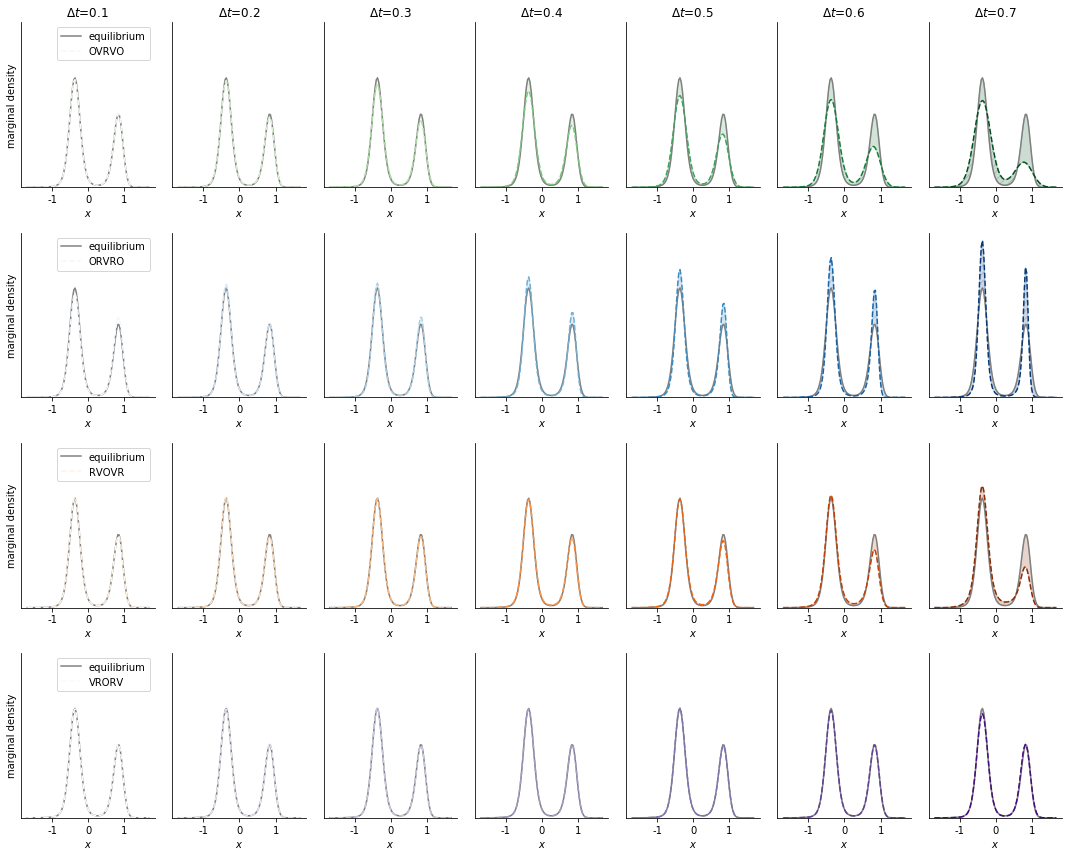

In [35]:
index = 1
scale_factor = 3
plt.figure(figsize=(5*scale_factor, 4 * scale_factor))
ax = None

first = True
for i in range(len(dts))[::8]:
    scheme = 'OVRVO'
    rho_xs = conf_space_rhos[scheme]
    
    ax = plt.subplot(4, len(dts_), index, sharey=ax)
    plot_rho_x_diff(rho_xs[i], ax=ax, scheme=scheme, color=colormaps[scheme][dts[i]])
    if first:
        plt.ylabel('marginal density')
        plt.legend(loc='best')
    index += 1
    first = False
    plt.title(r'$\Delta t$='+'{:.1f}'.format(dts[i]))

first = True
for i in range(len(dts))[::8]:
    scheme = 'ORVRO'
    rho_xs = conf_space_rhos[scheme]
    
    ax = plt.subplot(4, len(dts_), index, sharey=ax)
    plot_rho_x_diff(rho_xs[i], ax=ax, scheme=scheme, color=colormaps[scheme][dts[i]])
    if first:
        plt.ylabel('marginal density')
        plt.legend(loc='best')
    index += 1
    first = False
    
first = True
for i in range(len(dts))[::8]:
    
    scheme = 'RVOVR'
    rho_xs = conf_space_rhos[scheme]
    
    ax = plt.subplot(4, len(dts_), index, sharey=ax)
    plot_rho_x_diff(rho_xs[i], ax=ax, scheme=scheme, color=colormaps[scheme][dts[i]])
    if first:
        plt.ylabel('marginal density')
        plt.legend(loc='best')
    index += 1
    first = False
first = True
for i in range(len(dts))[::8]:
    scheme = 'VRORV'
    rho_xs = conf_space_rhos[scheme]
    
    ax = plt.subplot(4, len(dts_), index, sharey=ax)
    
    plot_rho_x_diff(rho_xs[i], ax=ax, scheme=scheme, color=colormaps[scheme][dts[i]])
    if first:
        plt.ylabel('marginal density')
        plt.legend(loc='best')
    index += 1
    first = False

plt.tight_layout()

plt.savefig('everything_on_grid.jpg', bbox_inches='tight', dpi=300)
plt.savefig('everything_on_grid.pdf')

In [36]:
plot_xlim = (-1.3,1.3)

In [37]:
i_s = list(range(len(dts))[::8])
i_s, [dts[i] for i in i_s]

([0, 8, 16, 24, 32, 40, 48],
 [0.10000000000000001,
  0.19795918367346937,
  0.29591836734693877,
  0.39387755102040811,
  0.49183673469387756,
  0.58979591836734691,
  0.68775510204081625])

In [38]:
i_s = [17,33,49]
[dts[i] for i in i_s]

[0.30816326530612248, 0.50408163265306116, 0.69999999999999996]

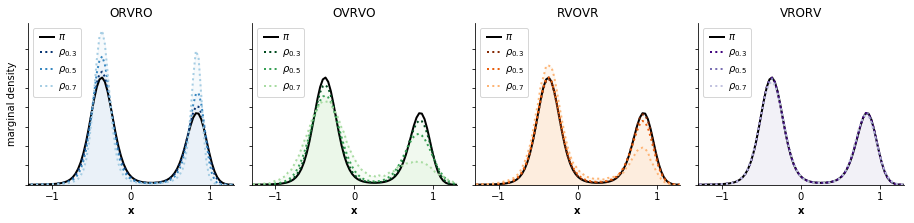

In [39]:
def plot_scheme(scheme, ax=None):
    
    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    linestyle_pi='solid'
    linestyle_rho='dotted'
    
    linewidth = 2
    
    plt.plot(x_grid, pi_x, color='black',
             linestyle=linestyle_pi, label=r'$\pi$', linewidth=linewidth)
    
    
    colors = dict(zip(i_s, [colormaps[scheme][dts[i]] for i in i_s][::-1]))
    
    for i in i_s:
        rho_x = conf_space_rhos[scheme][i]

        plt.plot(x_grid, rho_x, color=colors[i], linewidth=linewidth,
                 linestyle=linestyle_rho, label=r'$\rho_{' + '{:.1f}'.format(dts[i]) + r'}$')

        plt.fill_between(x_grid, rho_x, color=colormaps[scheme][dts[10]], alpha=0.15)
        
        plt.xlabel('$\mathbf{x}$')
    plt.legend(loc="upper left", numpoints=5, handletextpad=0.1)
    plt.ylim(0,)
    plt.xlim(*plot_xlim)
    plt.xticks([-1,0,1])
    plt.yticks(np.linspace(0,0.07,8), [''] * 8)
        
i = 1
ax = None

scale_factor = 3.2
plt.figure(figsize=(4 * scale_factor, 1 * scale_factor))

for scheme in sorted(schemes):
    ax = plt.subplot(1,4,i, sharey=ax)
    
    if i == 1:
        plt.ylabel('marginal density')
    
    plt.title(scheme)
    plot_scheme(scheme, ax)
    
    i += 1
plt.tight_layout()
plt.savefig('collapsed.jpg', dpi=300, bbox_inches='tight')
plt.savefig('collapsed.pdf', bbox_inches='tight')

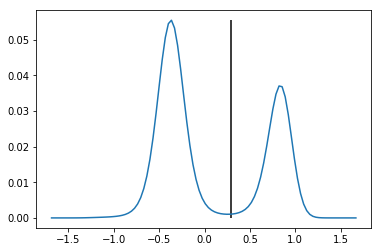

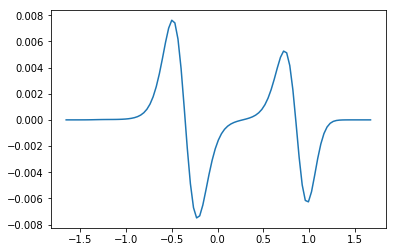

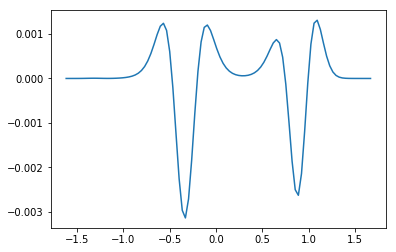

In [40]:
plt.plot(x_grid, pi_x)
plt.vlines(x2_grid[59], 0, max(pi_x))
plt.figure()
plt.plot(x_grid[1:], np.diff(pi_x))
plt.figure()
plt.plot(x_grid[2:], np.diff(np.diff(pi_x)))

In [41]:
x_grid_fine_left = np.linspace(-2,exact_x_midpoint,100000)
x_grid_fine_right = np.linspace(exact_x_midpoint,2,100000)

correct_free_energy = np.log(np.trapz(double_well.q(x_grid_fine_left), x_grid_fine_left) / np.trapz(double_well.q(x_grid_fine_right), x_grid_fine_right))

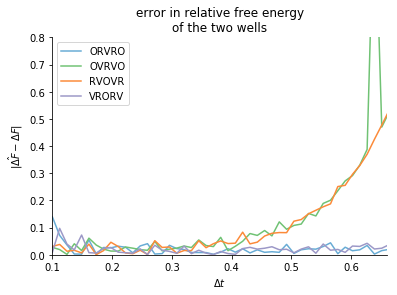

In [42]:
ax = plt.subplot(1,1,1)
def plot_free_energy_error(ax=None):
    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    for scheme in schemes:
        plt.plot(dts,
                 np.abs(free_energy_diffs[scheme] - correct_free_energy),
                 #'.',
                 label=scheme,
                 color=half_depth_colors[scheme])
    plt.legend(loc='upper left')

    plt.xlabel('$\Delta t$')
    plt.ylabel(r'$|\hat{\Delta F} - \Delta F|$')
    #plt.hlines(0,min(dts), max(dts), linestyles='--')
    #plt.error in 
    #plt.yscale('log')
    plt.title("error in relative free energy\nof the two wells")
    plt.ylim(0,0.8)
    plt.xlim(min(dts),0.66) # note -- need to re-run and show whole dt range
    
plot_free_energy_error(ax)
#plt.yscale('log')

In [43]:
# next, get the exact average potential energy...
x_grid_fine = np.linspace(-3,3,1000000)
Z = np.trapz(double_well.q(x_grid_fine), x_grid_fine)
def normalized_pi(x):
    return double_well.q(x) / Z

correct_average_potential = np.trapz(double_well.potential(x_grid_fine) * normalized_pi(x_grid_fine), x_grid_fine)
correct_average_potential

-1.2576646378975902

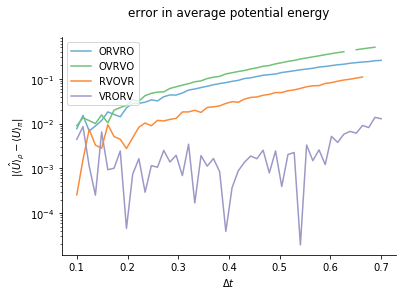

In [44]:
ax = plt.subplot(1,1,1)


def plot_potential_energy_error(ax=None):
    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    for scheme in schemes:
        plt.plot(dts, np.abs(avg_potentials[scheme] - correct_average_potential), label=scheme, color=half_depth_colors[scheme])
    plt.legend(loc='upper left')
    
    plt.xlabel('$\Delta t$')
    plt.ylabel(r'$|\hat{\langle U \rangle}_\rho - \langle U \rangle_\pi|$')
    plt.hlines(0,min(dts), max(dts), linestyles='--')
    plt.title("error in average potential energy\n")
plot_potential_energy_error(ax)
plt.yscale('log')

In [45]:
np.argmin(pi_x)

99

In [46]:
from scipy.stats import entropy

entropy(rho_x, pi_x)

0.01809878149643715

In [47]:
conf_space_rhos['VRORV']

[array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00020002e-07,
          1.00010001e-06,   2.80028003e-06,   8.40084008e-06,
          1.60016002e-05,   2.73027303e-05,   4.24042404e-05,
          7.37073707e-05,   9.75097510e-05,   1.31013101e-04,
          1.56315632e-04,   1.94219422e-04,   2.19821982e-04,
          2.67526753e-04,   3.25932593e-04,   4.00140014e-04,
          5.12351235e-04,   6.27462746e-04,   7.80978098e-04,
          1.00230023e-03,   1.43274327e-03,   1.94719472e-03,
          2.73857386e-03,   4.01290129e-03,   5.78707871e-03,
          8.26712671e-03,   1.17419742e-02,   1.64561456e-02,
          2.23406341e-02,   2.93545355e-02,   3.69725973e-02,
          4.41050105e-02,   5.03873387e-02,   5.42398240e-02,
          5.51743174e-02,   5.29675968e-02,   4.80016002e-02,
          4.14332433e-02,   3.38839884e-02,   2.65757576e-02,
          2.02029203e-02,   1.48823882e-02,   1.08291829e-02,
        

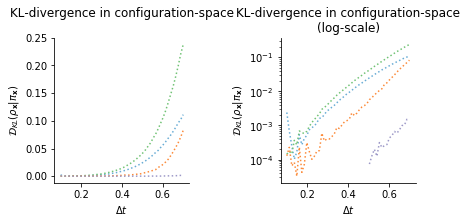

In [48]:
def plot_conf_summary(ax=None, log=True, linestyle='dotted'):

    for scheme in sorted(schemes):
        entropies = np.array([entropy(rho_x, pi_x) for rho_x in conf_space_rhos[scheme]])
        
        
        if (scheme == 'VRORV') and log:
            mask = dts > 0.5
        else:
            mask = dts > 0
        plt.plot(dts[mask], entropies[mask],
                 color=half_depth_colors[scheme],
                 linestyle=linestyle, label=scheme,
                )
    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
    plt.xlabel(r'$\Delta t$')
    plt.ylabel(r'$\mathcal{D}_{KL}(\rho_{\mathbf{x}} \| \pi_{\mathbf{x}})$')
    
    title = r'KL-divergence in configuration-space'
    if log:
        plt.yscale('log')
        title += '\n(log-scale)'
    else:
        title += '\n'
    plt.title(title)

scale_factor = 3.2

plt.figure(figsize=(2 * scale_factor, 1 * scale_factor))

# linear scale
ax = plt.subplot(1,2,1)
plot_conf_summary(ax, log=False)

# log scale
ax = plt.subplot(1,2,2)
plot_conf_summary(ax, log=True)

plt.tight_layout()

plt.savefig('conf_summary.jpg', dpi=300, bbox_inches='tight')

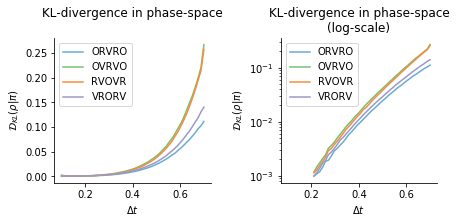

In [49]:
def plot_phase_space_summary(ax=None, log=True):
    
    
    for scheme in sorted(schemes):
        entropies = np.array([entropy(rho.flatten(), exact_hist_xv.flatten()) for rho in phase_space_rhos[scheme]])
        
        if log:
            mask = dts > 0.2
        else:
            mask = dts > 0
        plt.plot(dts[mask], entropies[mask],
                 color=half_depth_colors[scheme],
                 linestyle='solid', label=scheme,
                )
    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
    plt.xlabel(r'$\Delta t$')
    plt.ylabel(r'$\mathcal{D}_{KL}(\rho \| \pi)$')
    
    plt.legend(loc='upper left')
    title = r'KL-divergence in phase-space'
    if log:
        plt.yscale('log')
        title += '\n(log-scale)'
    else:
        title += '\n'
    plt.title(title)

scale_factor = 3.2

plt.figure(figsize=(2 * scale_factor, 1 * scale_factor))

# linear scale
ax = plt.subplot(1,2,1)
plot_phase_space_summary(ax, log=False)


# log scale
ax = plt.subplot(1,2,2, sharex=ax)
plot_phase_space_summary(ax, log=True)


plt.tight_layout()

plt.savefig('phase_space_summary.jpg', dpi=300, bbox_inches='tight')

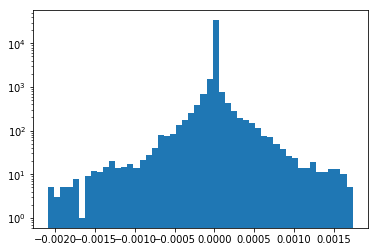

In [50]:
differences = []
for scheme in sorted(schemes):
    difference = (exact_hist_xv - phase_space_rhos[scheme][-1]).T
    differences.append(difference)
    
all_differences = np.hstack([d.flatten() for d in differences])
plt.hist(all_differences, bins=50);
plt.yscale('log')

In [51]:
version_counter = 0

In [52]:
x_grid[0], x_grid[-1]

(-1.6849073729894668, 1.6677090344366561)

0.000172746860618
0.000182925054118
0.000102931075796
0.000129002162126


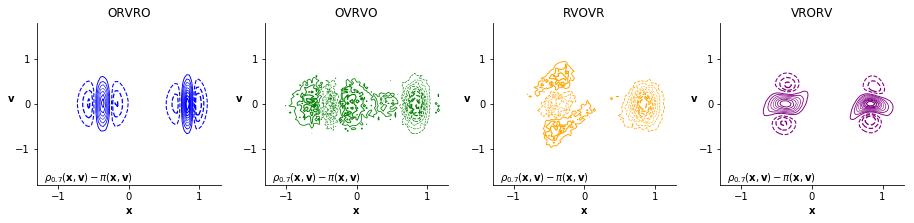

In [82]:
scale_factor = 3.2
plt.figure(figsize=(4*scale_factor,1*scale_factor))
n_levels = 15
#levels = np.linspace(-0.0001,0.0001, n_levels)
#levels = sorted(all_differences)[::int(len(all_differences) / n_levels)]
linewidths = np.abs(np.linspace(-1,1,n_levels)) + 0.5



def plot_contours_scheme(scheme='RVOVR', ax=None, kl_integrand=False):
    
    
    rho = phase_space_rhos[scheme][-1]
    extent=(min(x_grid), max(x_grid), min(v_grid), max(v_grid))
    
    # if you want to plot kl integrand
    
    if kl_integrand:
        rho_reg = (0.00001 + rho)
        rho_reg /= np.sum(rho)
        difference = - np.log((rho_reg / exact_hist_xv).T)
        title = r'$\log \left( \frac{\rho(\mathbf{x}, \mathbf{v})}{\pi(\mathbf{x}, \mathbf{v})} \right)$'
    
    
    # if you want to plot the densities subtracted from each other
    else:
        difference = (rho - exact_hist_xv).T
        title = r'$\rho_{0.7}(\mathbf{x}, \mathbf{v}) - \pi(\mathbf{x}, \mathbf{v})$'
    
    
    #inv_cdf_levels = sorted(difference.flatten())[::int(len(difference.flatten()) / n_levels)]
    evenly_spaced_levels = np.linspace(np.min(difference), np.max(difference), n_levels)
    levels = sorted(evenly_spaced_levels[np.argsort(np.abs(evenly_spaced_levels))][1:])
    
    #evenly_spaced_levels = sorted(np.abs())[3:]
    
    
    #evenly_spaced_levels = list(np.linspace(np.min(difference), np.max(difference), n_levels))
    #levels.extend()
    #levels = sorted(list(set(inv_cdf_levels + evenly_spaced_levels)))
    #levels = evenly_spaced_levels
    print(np.min(np.abs(levels)))
    
    # playing around with where to put the contours...
    #levels = np.linspace(np.min(difference), np.max(difference), n_levels)
    
    plt.contour(difference,
                colors=colors[scheme][:-1],
                levels=levels,
                linewidths=linewidths,
                extent=extent, label=title
               )
    #plt.colorbar()
    
    #plt.contourf(difference, cmap=colors[scheme] + '_r', levels=levels,extent=extent,alpha=0.05)

    plt.xlim(*plot_xlim)
    plt.ylim(-1.8,1.8)

    plt.title(scheme)
    
    plt.yticks([-1,0,1])
    plt.xticks([-1,0,1])
    plt.xlabel(r'$\mathbf{x}$')
    plt.ylabel(r'$\mathbf{v}$',rotation=0)
    
    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.text(plot_xlim[0] + 0.1,-1.7, title)
    
    



i = 1
ax = None
for scheme in sorted(schemes):
    ax = plt.subplot(1,4,i)
    plot_contours_scheme(scheme, ax)
    i += 1
    
    
    
version_counter += 1

plt.tight_layout()
plt.savefig('contours_v{}.jpg'.format(version_counter), bbox_inches='tight', dpi=300)

In [83]:
# putting it all together!

# 2 rows: configuration, and full phase-space
# 5 columns: (summary, ORVRO, OVRVO, RVOVR, VRORV)

# currently just clicking and dragging it around in keynote, but once we settle on how this is supposed to look,
# I'll generate the whole thing altogether

0.000172746860618
0.000182925054118
0.000102931075796
0.000129002162126


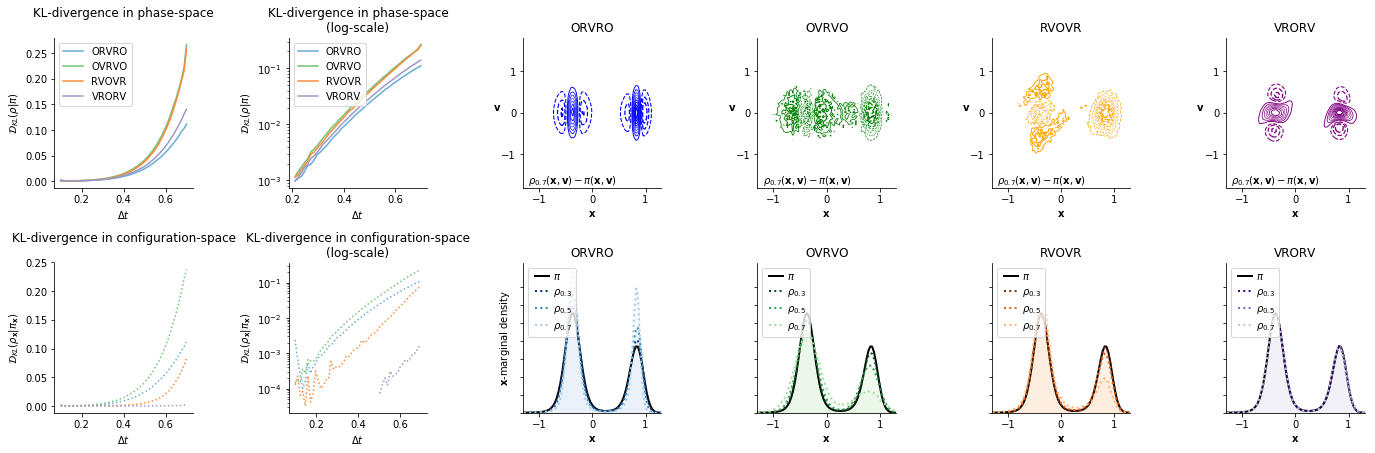

In [84]:
scale_factor = 3.2


n_rows = 2
n_cols = 6
plt.figure(figsize=(n_cols * scale_factor, n_rows * scale_factor))

index = 1

# linear scale phase-space summary
ax = plt.subplot(n_rows, n_cols, index)
plot_phase_space_summary(ax, log=False)
index += 1

# log scale phase-space summary
ax = plt.subplot(n_rows, n_cols, index)
plot_phase_space_summary(ax, log=True)
index += 1

# phase-space contour plots
ax = None
for scheme in sorted(schemes):
    ax = plt.subplot(n_rows, n_cols, index, sharey=ax)
        
    plt.title(scheme)
    plot_contours_scheme(scheme, ax=ax)
    index += 1

# linear scale conf summary
ax = plt.subplot(n_rows, n_cols, index)
plot_conf_summary(ax, log=False)
index += 1

# log scale conf summary
ax = plt.subplot(n_rows, n_cols, index)
plot_conf_summary(ax, log=True)
index += 1


# conf plots
ax = None

for scheme in sorted(schemes):
    ax = plt.subplot(n_rows, n_cols,index, sharey=ax)
    
    # only put a y-label on the left-most one
    if scheme == sorted(schemes)[0]:
        plt.ylabel('$\mathbf{x}$-marginal density')
        
    plt.title(scheme)
    plot_scheme(scheme)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    index += 1

plt.tight_layout()
plt.savefig('fig1_draft.pdf', bbox_inches='tight')

0.000172746860618
0.000182925054118
0.000102931075796
0.000129002162126


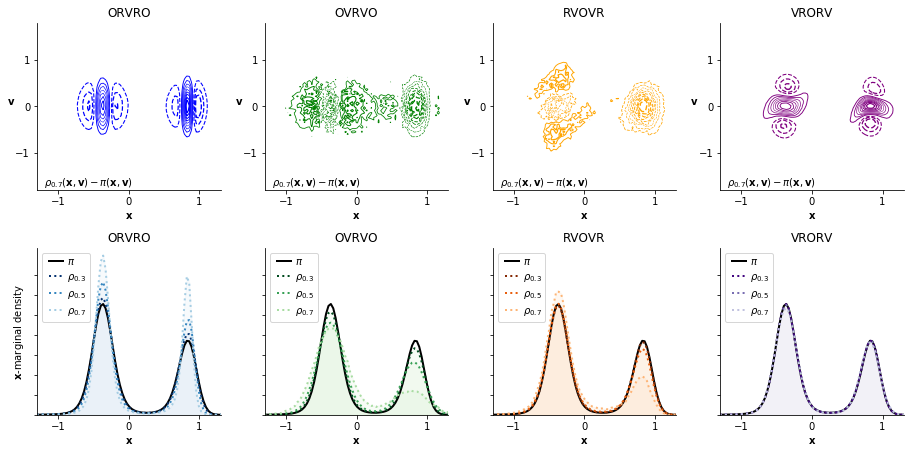

In [85]:
scale_factor = 3.2

#page_width = 7
#scale_factor = page_width / n_cols

n_rows = 2
n_cols = 4

plt.figure(figsize=(n_cols * scale_factor, n_rows * scale_factor))


index = 1

# phase-space contour plots
ax = None
for scheme in sorted(schemes):
    ax = plt.subplot(n_rows, n_cols, index, sharey=ax)
        
    plt.title(scheme)
    plot_contours_scheme(scheme, ax=ax)
    index += 1

# conf plots
ax = None

for scheme in sorted(schemes):
    ax = plt.subplot(n_rows, n_cols,index, sharey=ax)
    
    # only put a y-label on the left-most one
    if scheme == sorted(schemes)[0]:
        plt.ylabel('$\mathbf{x}$-marginal density')
        
    plt.title(scheme)
    plot_scheme(scheme)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    index += 1

plt.tight_layout()
plt.savefig('double_well_distributions.pdf', bbox_inches='tight')

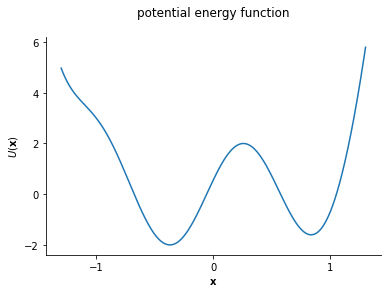

In [86]:
def plot_potential_energy_function(ax=None):
    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    x_grid_fine = np.linspace(plot_xlim[0], plot_xlim[1], 10000)
    U = double_well.potential(x_grid_fine)
    plt.plot(x_grid_fine, U, label=r'$U$')
    
    #plt.hlines(0,*plot_xlim)
    #print(U.min(), U.max())
    plt.xlabel(r'$\mathbf{x}$')
    plt.ylabel(r'$U(\mathbf{x})$')
    plt.yticks([-2,0,2,4,6])
    plt.xticks([-1,0,1])
    plt.title('potential energy function\n')
    #plt.xlim(*plot_xlim)
    #plt.ylim(min(U) - 0.1, max(pi) + 0.1)
ax = plt.subplot(1,1,1)
plot_potential_energy_function(ax)


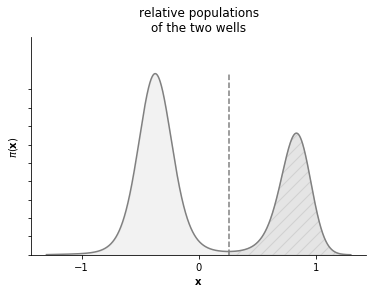

In [87]:
def plot_well_populations(ax=None):
    if type(ax) != type(None):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    
    x_grid_fine = np.linspace(plot_xlim[0], plot_xlim[1], 10000)
    U = double_well.potential(x_grid_fine)
    pi = double_well.q(x_grid_fine) / Z
    
    plt.plot(x_grid_fine, pi, label=r'$\pi$', color='grey')
    
    left = x_grid_fine < exact_x_midpoint
    right = x_grid_fine >= exact_x_midpoint
    plt.fill_between(x_grid_fine[left], pi[left], alpha=0.1, color='grey')
    plt.fill_between(x_grid_fine[right], pi[right], alpha=0.2, color='grey', hatch='//')
    
    plt.yticks(np.linspace(0,1.5,10), ['']*10)
    #plt.legend(loc='best')
    
    
    plt.title('relative populations\nof the two wells')
    
    plt.xlabel(r'$\mathbf{x}$')
    plt.ylabel(r'$\pi(\mathbf{x})$')
    
    plt.vlines(exact_x_midpoint, 0, max(pi), linestyles='--', color='grey')
    
    #plt.fill_betweenx(y=(0,max(pi)), x1=min(x_grid_fine), x2=exact_x_midpoint, alpha=0.1, hatch='/')
    
    plt.xticks([-1,0,1])
    plt.ylim(0,1.2 * max(pi))
    
ax = plt.subplot(1,1,1)
plot_well_populations(ax)

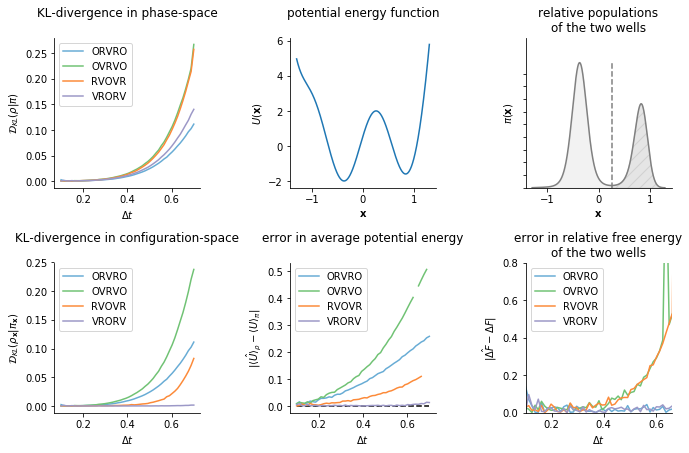

In [88]:
scale_factor = 3.2


n_rows = 2
n_cols = 3
plt.figure(figsize=(n_cols * scale_factor, n_rows * scale_factor))

index = 1

# linear scale phase-space summary
ax = plt.subplot(n_rows, n_cols, index)
plot_phase_space_summary(ax, log=False)
index += 1

# to-do: make this an inset axis...
#ax = plt.axes([0,0,0.1,0.1])

#ax = plt.subplot(n_rows, n_cols, index, sharex=ax)
#plot_phase_space_summary(ax, log=True)
#index += 1
ax = plt.subplot(n_rows, n_cols, index)
plot_potential_energy_function(ax)
index += 1


ax = plt.subplot(n_rows, n_cols, index)
plot_well_populations(ax)
index += 1



#index += 2 # how to use this space: plot 

# linear scale conf summary
ax = plt.subplot(n_rows, n_cols, index)
plot_conf_summary(ax, log=False, linestyle='solid')
plt.legend(loc='upper left')
index += 1

## log scale conf summary
#ax = plt.subplot(n_rows, n_cols, index, sharex=ax)
#plot_conf_summary(ax, log=True)
#index += 1

# average potential energy
ax = plt.subplot(n_rows, n_cols, index)
plot_potential_energy_error(ax)
index += 1

# free energies of the two wells
ax = plt.subplot(n_rows, n_cols, index)
plot_free_energy_error(ax)
index += 1


plt.tight_layout()
plt.savefig('double_well_summaries.pdf', bbox_inches='tight', dpi=300)

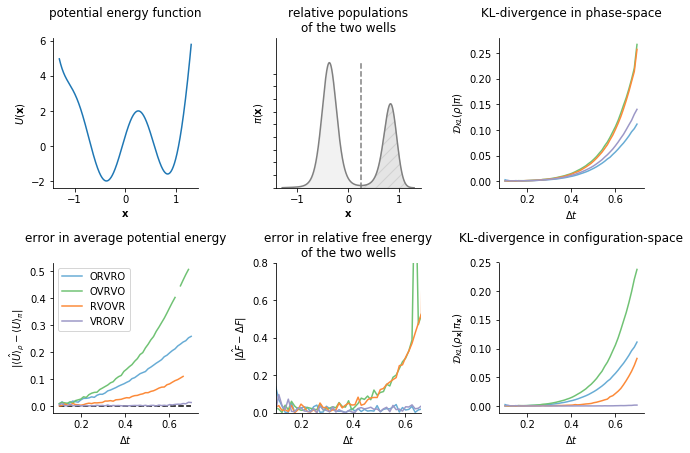

In [89]:
scale_factor = 3.2


n_rows = 2
n_cols = 3
plt.figure(figsize=(n_cols * scale_factor, n_rows * scale_factor))

index = 1

# to-do: make this an inset axis...
#ax = plt.axes([0,0,0.1,0.1])

#ax = plt.subplot(n_rows, n_cols, index, sharex=ax)
#plot_phase_space_summary(ax, log=True)
#index += 1
ax = plt.subplot(n_rows, n_cols, index)
plot_potential_energy_function(ax)
index += 1


ax = plt.subplot(n_rows, n_cols, index)
plot_well_populations(ax)
index += 1

# linear scale phase-space summary
ax = plt.subplot(n_rows, n_cols, index)
plot_phase_space_summary(ax, log=False)
ax.legend().set_visible(False)
index += 1


#index += 2 # how to use this space: plot 

## log scale conf summary
#ax = plt.subplot(n_rows, n_cols, index, sharex=ax)
#plot_conf_summary(ax, log=True)
#index += 1

# average potential energy
ax = plt.subplot(n_rows, n_cols, index)
plot_potential_energy_error(ax)
index += 1

# free energies of the two wells
ax = plt.subplot(n_rows, n_cols, index)
plot_free_energy_error(ax)
ax.legend().set_visible(False)
index += 1


# linear scale conf summary
ax = plt.subplot(n_rows, n_cols, index)
plot_conf_summary(ax, log=False, linestyle='solid')
#plt.legend(loc='upper left')
index += 1

plt.tight_layout()
plt.savefig('double_well_summaries_different_order.jpg', bbox_inches='tight', dpi=300)

In [62]:
def get_acceptance_ratio(x0, v0, scheme, dt):
    """Compute the acceptance ratio of a proposal starting in (x0,v0)"""
    return min(1, np.exp(-integrate(x0,v0,2, dt=dt, scheme=scheme)[-1][-1]))

def estimate_acceptance_rate(scheme, dt, n_samples=100000):
    """Collect many samples of the acceptance ratio, starting i.i.d. from eequilibrium.
    The average of these is a low-variance estimator of the acceptance rate."""
    acceptance_ratios = np.zeros(n_samples)
    for i in range(n_samples):
        x0 = double_well.sample_x_from_equilibrium()
        v0 = double_well.sample_v_given_x(x0)
        acceptance_ratios[i] = get_acceptance_ratio(x0, v0, scheme, dt)
    return acceptance_ratios

def get_acceptance_rate_curve(scheme):
    """Get acceptance rate +/- stderr as a function of timestep."""
    acceptance_rates = np.zeros(len(dts))
    acceptance_rates_unc = np.zeros(len(dts))
    
    for i in tqdm(range(len(dts))):
        dt = dts[i]
        acceptance_ratios = estimate_acceptance_rate(scheme, dt)
        acceptance_rates[i] = np.mean(acceptance_ratios)
        acceptance_rates_unc[i] = 1.96 * np.std(acceptance_ratios) / np.sqrt(len(acceptance_ratios))
    return acceptance_rates, acceptance_rates_unc

In [63]:
acceptance_ratios = estimate_acceptance_rate('VRORV', 0.6)

In [64]:
acceptance_ratios.mean(), np.std(acceptance_ratios), np.std(acceptance_ratios) / np.sqrt(len(acceptance_ratios))

(0.84827685406199538, 0.22585112797455953, 0.00071420397651777924)

In [65]:
acceptance_rate_curves = {}
acceptance_rate_unc_curves = {}
for scheme in schemes:
    mean, stderr = get_acceptance_rate_curve(scheme)
    acceptance_rate_curves[scheme] = mean
    acceptance_rate_unc_curves[scheme] = stderr

100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


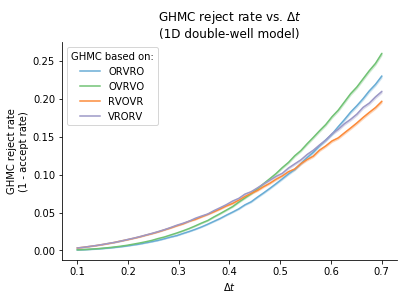

In [66]:
plt.figure()
ax = plt.subplot(1,1,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for scheme in schemes:
    
    mean, stderr = (1 - acceptance_rate_curves[scheme]), acceptance_rate_unc_curves[scheme]
    
    plt.plot(dts, mean, color=half_depth_colors[scheme], label=scheme)
    plt.fill_between(dts, mean - stderr, mean + stderr, color=half_depth_colors[scheme], alpha=0.25)
plt.legend(loc='best', title='GHMC based on:')
#plt.ylim(0.5,1)
plt.xlabel('$\Delta t$')
plt.ylabel("GHMC reject rate\n(1 - accept rate)")
plt.title('GHMC reject rate vs. $\Delta t$' +  '\n(1D double-well model)')
plt.savefig('double_well_reject_rate.jpg', dpi=300, bbox_inches='tight')

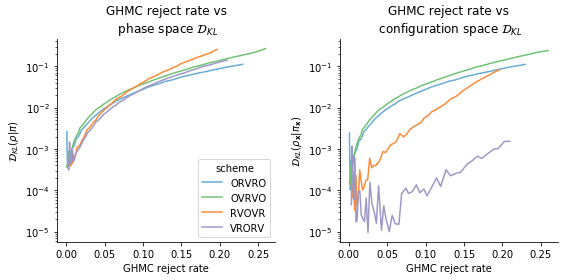

In [67]:
plt.figure(figsize=(8,4))
ax = plt.subplot(1,2,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for scheme in schemes:
    D_KL_phase_space = np.array([entropy(rho.flatten(), exact_hist_xv.flatten()) for rho in phase_space_rhos[scheme]])
    acceptance_rate = acceptance_rate_curves[scheme]
    plt.plot(1 - acceptance_rate, D_KL_phase_space, color=half_depth_colors[scheme], label=scheme)
    plt.xlabel('GHMC reject rate')
    plt.ylabel(r'$\mathcal{D}_{KL}(\rho \| \pi)$')
plt.title('GHMC reject rate vs\n phase space ' +  r'$\mathcal{D}_{KL}$')
plt.legend(loc='best', title='scheme')

ax = plt.subplot(1,2,2, sharey=ax, sharex=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for scheme in schemes:
    D_KL_conf_space = np.array([entropy(rho_x, pi_x) for rho_x in conf_space_rhos[scheme]])
    acceptance_rate = acceptance_rate_curves[scheme]
    plt.plot(1 - acceptance_rate, D_KL_conf_space,  color=half_depth_colors[scheme], label=scheme)
    plt.xlabel('GHMC reject rate')
    plt.ylabel(r'$\mathcal{D}_{KL}(\rho_{\mathbf{x}} \| \pi_{\mathbf{x}})$')
plt.title('GHMC reject rate vs\n configuration space ' +  r'$\mathcal{D}_{KL}$')
#plt.legend(loc='best', title='scheme')


#if log
plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()
plt.savefig('double_well_acceptance_rate_vs_D_KL_log.jpg', dpi=300, bbox_inches='tight')

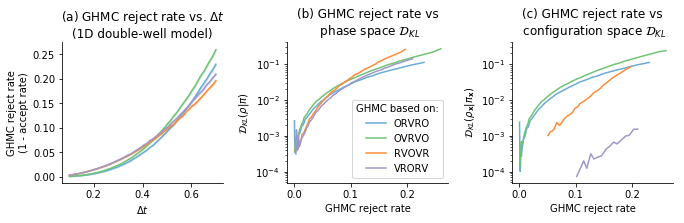

In [69]:
scale_factor = 3.2
n_cols = 3
n_rows = 1

plt.figure(figsize=(n_cols * scale_factor,n_rows * scale_factor))

ax = plt.subplot(n_rows,n_cols,1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for scheme in schemes:
    
    mean, stderr = (1 - acceptance_rate_curves[scheme]), acceptance_rate_unc_curves[scheme]
    
    plt.plot(dts, mean, color=half_depth_colors[scheme], label=scheme)
    plt.fill_between(dts, mean - stderr, mean + stderr, color=half_depth_colors[scheme], alpha=0.25)
#plt.legend(loc='best', title='GHMC based on:')
#plt.ylim(0.5,1)
plt.xlabel('$\Delta t$')
plt.ylabel("GHMC reject rate\n(1 - accept rate)")
plt.title('(a) GHMC reject rate vs. $\Delta t$' +  '\n(1D double-well model)')

ax = plt.subplot(n_rows,n_cols,2)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for scheme in schemes:
    
    #dts_, D_KL_phase_space = get_near_eq_curves_with_unc(scheme, 'full')[:2]
    #acceptance_rate = np.array([acceptance_rate_curves[scheme][i] for i in range(len(dts)) if dts[i] in dts_])
    D_KL_phase_space = np.array([entropy(rho.flatten(), exact_hist_xv.flatten()) for rho in phase_space_rhos[scheme]])
    acceptance_rate = acceptance_rate_curves[scheme]
    plt.plot(1 - acceptance_rate, D_KL_phase_space, color=half_depth_colors[scheme], label=scheme)
    plt.xlabel('GHMC reject rate')
    plt.ylabel(r'$\mathcal{D}_{KL}(\rho \| \pi)$')
plt.title('(b) GHMC reject rate vs\n phase space ' +  r'$\mathcal{D}_{KL}$')
plt.legend(loc='best', title='GHMC based on:')

ax = plt.subplot(n_rows,n_cols,3, sharey=ax, sharex=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for scheme in schemes:
    #dts_, D_KL_conf_space = get_near_eq_curves_with_unc(scheme, 'configuration')[:2]

    D_KL_conf_space = np.array([entropy(rho_x, pi_x) for rho_x in conf_space_rhos[scheme]])
    #acceptance_rate = np.array([acceptance_rate_curves[scheme][i] for i in range(len(dts)) if dts[i] in dts_])
    acceptance_rate = acceptance_rate_curves[scheme]
    mask = acceptance_rate > -1
    if scheme == 'RVOVR':
        mask = (1 - acceptance_rate) > 0.05
    elif scheme == 'VRORV':
        mask = (1 - acceptance_rate) > 0.1
    
    plt.plot(1 - acceptance_rate[mask],  D_KL_conf_space[mask], color=half_depth_colors[scheme], label=scheme)
    plt.xlabel('GHMC reject rate')
    plt.ylabel(r'$\mathcal{D}_{KL}(\rho_{\mathbf{x}} \| \pi_{\mathbf{x}})$')
plt.title('(c) GHMC reject rate vs\n configuration space ' +  r'$\mathcal{D}_{KL}$')
#plt.legend(loc='best', title='scheme')


plt.yscale('log')
#plt.xscale('log')

plt.tight_layout()
plt.savefig('double_well_acceptance_rate_vs_D_KL_log.jpg', dpi=300, bbox_inches='tight')